# 电影推荐实验

本实验用协同过滤技术分析用户对电影的评分数据，并基于这个数据建立一个推荐系统。此实验中，我们使用的数据集是MovieLens数据集中的ml-1m，利用聚类算法，将用户群体划分，再通过模型训练运用，形成推荐结果

### 导入基本工具库
执行下面方框中的这段代码，可以导入本次实验中使用的Python开发基本工具库。

In [322]:
import numpy as np
import pandas as pd

## 数据集导入以及查看

In [323]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
user_df = pd.read_csv('./ml-1m/users.dat',
                      sep='::',
                      header=None,
                      names=unames,
                      engine='python')
# 电影信息
mnames = ['movie_id', 'title', 'genres']
movies_df = pd.read_csv('./ml-1m/movies.dat',
                        sep='::',
                        header=None,
                        names=mnames,
                        engine='python',
                        encoding='ISO-8859-1')
# 评分信息
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('./ml-1m/ratings.dat',
                         sep='::',
                         header=None,
                         engine='python',
                         names=rnames)

In [324]:
user_df=user_df[:610]
user_df

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
605,606,F,1,10,49507
606,607,M,25,0,43614
607,608,M,18,4,18011
608,609,M,25,7,10012


In [325]:
movies_df

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [326]:
ratings_df

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


### 数据预处理

In [327]:
#将时间戳转换为年份
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df.rename(columns={'timestamp': 'time'}, inplace=True)
ratings_df.tail()

,user_id,movie_id,rating,time
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48
1000208,6040,1097,4,2000-04-26 02:19:29


In [328]:
#将性别字段进行数值编码
from sklearn.preprocessing import LabelEncoder
 
# 假设df是你的数据框，其中"color"是一个分类变量
le = LabelEncoder()
user_df['gender_encoding'] = le.fit_transform(user_df['gender'])
# user_df.drop(['gender'], axis=1, inplace=True)
user_df.head()

,user_id,gender,age,occupation,zip,gender_encoding
0,1,F,1,10,48067,0
1,2,M,56,16,70072,1
2,3,M,25,15,55117,1
3,4,M,45,7,02460,1
4,5,M,25,20,55455,1


### 数据重复值查看以及处理

In [329]:
#重复值查看以及处理
user_df.duplicated().value_counts()

False    610
Name: count, dtype: int64

In [330]:
movies_df.duplicated().value_counts()

False    3883
Name: count, dtype: int64

In [331]:

ratings_df.duplicated().value_counts()

False    1000209
Name: count, dtype: int64

In [332]:
#异常值查看
user_df.describe()

,user_id,age,occupation,gender_encoding
count,610.000000,610.000000,610.000000,610.000000
mean,305.500000,30.188525,8.272131,0.708197
std,176.236111,12.635818,6.385126,0.454965
min,1.000000,1.000000,0.000000,0.000000
25%,153.250000,18.000000,3.000000,0.000000
50%,305.500000,25.000000,7.000000,1.000000
75%,457.750000,35.000000,14.000000,1.000000
max,610.000000,56.000000,20.000000,1.000000


In [333]:
ratings_df.describe()

,user_id,movie_id,rating,time
count,1.000209e+06,1.000209e+06,1.000209e+06,1000209
mean,3.024512e+03,1.865540e+03,3.581564e+00,2000-10-22 19:41:35.404665856
min,1.000000e+00,1.000000e+00,1.000000e+00,2000-04-25 23:05:32
25%,1.506000e+03,1.030000e+03,3.000000e+00,2000-08-03 11:37:17
50%,3.070000e+03,1.835000e+03,4.000000e+00,2000-10-31 18:46:46
75%,4.476000e+03,2.770000e+03,4.000000e+00,2000-11-26 06:42:19
max,6.040000e+03,3.952000e+03,5.000000e+00,2003-02-28 17:49:50
std,1.728413e+03,1.096041e+03,1.117102e+00,NaN


### 数据集数据可视化

In [334]:
rating_val_count = ratings_df.rating.value_counts()
fig = px.bar(rating_val_count, x=rating_val_count.index, y=rating_val_count, text=rating_val_count,
             labels={
                 "index": "Ratings",
                 'y': 'Number of Ratings'},
             color=rating_val_count
             )
fig.update_traces(textposition='outside')
fig.update_layout(title_text='评分频次图—金振宇',
                  title_x=0.5, title_font=dict(size=24))
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)'})
fig.show()

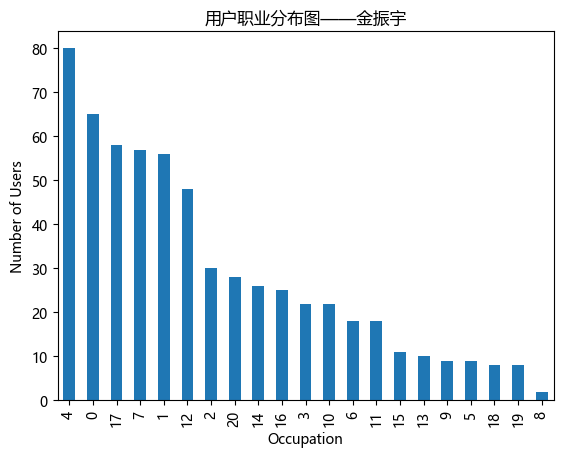

In [335]:
#职业用户人数占比
 
users_by_occupation = user_df.groupby('occupation').size()
# 对用户人数进行排序
sorted_users_by_occupation = users_by_occupation.sort_values(ascending=False)
sorted_users_by_occupation.plot(kind='bar')
plt.xlabel('Occupation')
plt.ylabel('Number of Users')
plt.title('用户职业分布图——金振宇')
plt.show()

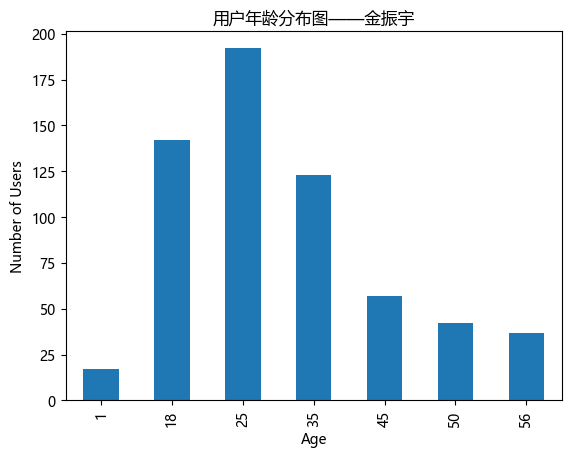

In [336]:
# 根据年龄对用户进行分组，并统计每个年龄段的用户数量
users_by_age = user_df.groupby('age').size()
users_by_age.plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.title('用户年龄分布图——金振宇')
plt.show()
#观察柱状图，符合正态分布

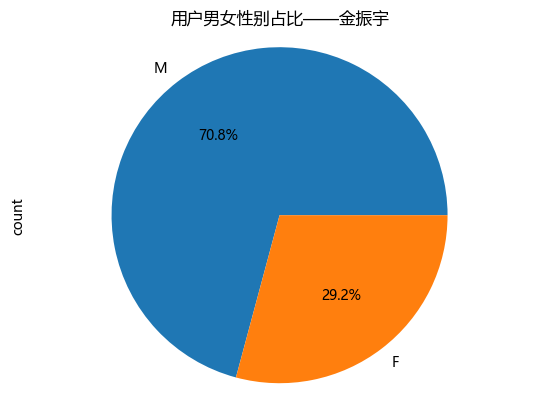

In [337]:
#用户男女性别占比
users_by_gender = user_df['gender'].value_counts()
users_by_gender.plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.title('用户男女性别占比——金振宇')
plt.show()

<Figure size 1200x800 with 0 Axes>

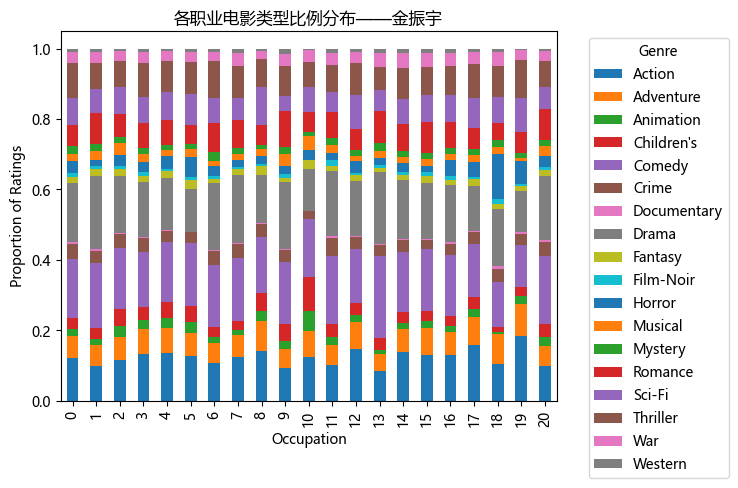

In [338]:
movies_data = pd.concat([movies_df, movies_df['genres'].str.get_dummies(sep='|')], axis=1)
movies_data.drop('genres', axis=1, inplace=True)
 
#%%
#每个职业，用户最关注的电影类型(最关注的电影类型，非最喜欢的电影类型，即评论数最多的电影类型)
merged_data = pd.merge(pd.merge(user_df, ratings_df), movies_data)
genre_columns = ['Action', 'Adventure', 'Animation', "Children\'s", 'Comedy', 'Crime', 'Documentary', 'Drama',
                 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
                 'Western']
genre_by_occupation = merged_data.groupby('occupation')[genre_columns].sum()
 
# 计算每个职业对所有电影类型的评论数
total_ratings_by_occupation = genre_by_occupation.sum(axis=1)
 
# 计算每个职业对每种电影类型的评论数比例
genre_proportions_by_occupation = genre_by_occupation.divide(total_ratings_by_occupation, axis=0)
 
plt.figure(figsize=(12, 8))
genre_proportions_by_occupation.plot(kind='bar', stacked=True)
plt.title('各职业电影类型比例分布——金振宇')
plt.xlabel('Occupation')
plt.ylabel('Proportion of Ratings')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 1200x800 with 0 Axes>

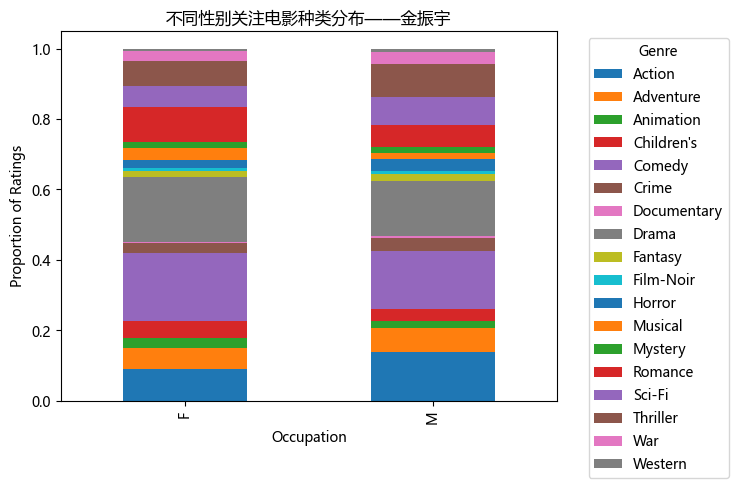

In [339]:
#每个性别用户最关注的电影类型(最关注的电影类型，非最喜欢的电影类型，即评论数最多的电影类型)
genre_by_gender = merged_data.groupby('gender')[genre_columns].sum()
 
total_ratings_by_gender = genre_by_gender.sum(axis=1)
 
# 计算每个职业对每种电影类型的评论数比例
genre_proportions_by_gender = genre_by_gender.divide(total_ratings_by_gender, axis=0)
plt.figure(figsize=(12, 8))
genre_proportions_by_gender.plot(kind='bar', stacked=True)
plt.title('不同性别关注电影种类分布——金振宇')
plt.xlabel('Occupation')
plt.ylabel('Proportion of Ratings')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

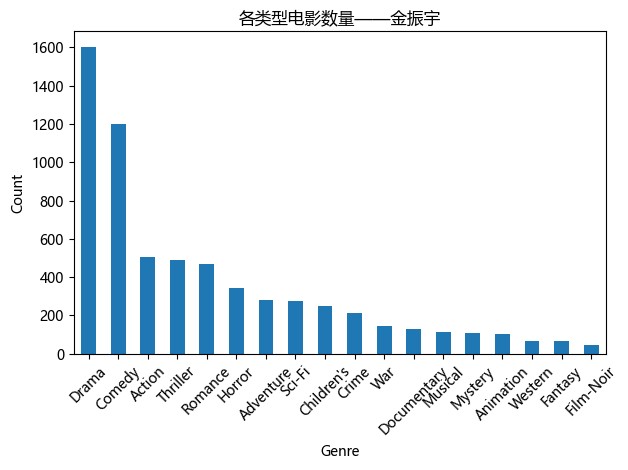

In [340]:
#每个电影类型的电影数量
genres_df = movies_df['genres'].str.get_dummies('|')
# 计算每个电影类型的数量
genre_counts = genres_df.sum().sort_values(ascending=False)
 
genre_counts.plot(kind='bar')
plt.title('各类型电影数量——金振宇')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 基于影评的用户群体分类

按照用户对每个电影类型的平均评分来划分群体

本设计尝试构建用户-电影类型平均评分矩阵做聚类，

    使用K-means算法、层次聚类和高斯混合模型进行训练。并使用PCA算法对矩阵降到二维，虽然会丢失一部分原数据的信息，但可以降低计算复杂度，也方便聚类结果的可视化。
    K-means算法网格搜索的超参数：n_clusters为簇的数量；init为初始质心选择方法；algorithm为均值算法的实现方式。
    次聚类网格搜索的超参数为：n_clusters；affinity为两个对象之间的相似性度量；linkage为计算簇之间的距离的方式。
    高斯混合模型网格搜索超参数为：n_components为保留的特征的数量，max_iter为最大迭代次数。

In [341]:
genres_split = movies_df['genres'].str.get_dummies('|')
movies = pd.concat([movies_df, genres_split], axis=1)

# 合并ratings和movies表格，根据movieId连接
merged_data = pd.merge(ratings_df, movies, on='movie_id')
user_movie_matrix = ratings_df.pivot_table(index='user_id', columns='movie_id', values='rating')
user_movie_matrix = user_movie_matrix.fillna(0)
# 统计每个用户对每个电影类型的平均评分
avg_ratings_by_genre = merged_data.groupby(['user_id'])[genres_split.columns].mean()
# avg_ratings_by_genre
user_movie_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [342]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
 
 
#PCA降维
from sklearn.decomposition import PCA
 
pca = PCA(n_components=2)
pca_data = pca.fit_transform(user_movie_matrix)

### 求最佳参数
通过网格搜索，得到最佳参数组合和最佳评分，总结出最优聚类算法

#### k-means算法

    1.进行网格搜索最佳参数
    2.创建K均值算法模型
    3.创建网格搜索对象
    4.在训练集上拟合网格搜索对象
    5.输出最佳参数组合和最佳评分

In [343]:
#进行网格搜索最佳参数
param_grid = {
    'n_clusters': [3, 4, 5, 6],  # 簇的数量
    'init': ['random', 'k-means++'],  # 初始质心选择方法
    'algorithm': ['lloyd', 'elkan'],  # K均值算法的实现方式
}
 
# 创建K均值算法模型
kmeans = KMeans(n_init="auto")
 
# 创建网格搜索对象
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid)
 
# 在训练集上拟合网格搜索对象
grid_search.fit(pca_data)
 
# 输出最佳参数组合和最佳评分
print("最佳参数组合:", grid_search.best_params_)
print("最佳评分:", grid_search.best_score_)

最佳参数组合: {'algorithm': 'lloyd', 'init': 'random', 'n_clusters': 6}
最佳评分: -73563.84214086206


可以看出最佳参数组合 {'algorithm': 'elkan', 'init': 'k-means++', 'n_clusters': 6}，后续按照该标准进行分类

In [344]:
# 将每个用户的簇标签作为该用户的分类结果
best_model = grid_search.best_estimator_
best_model.fit(pca_data)
labels = best_model.labels_
pd.DataFrame(labels).value_counts()

0
0    3216
3    1034
1     830
4     418
5     392
2     150
Name: count, dtype: int64

In [345]:
from matplotlib.font_manager import FontProperties
# Windows系统的字体路径
font_path = 'C:\\Windows\\Fonts\\msyh.ttc'
font_prop = FontProperties(fname=font_path)

# 设置matplotlib的字体属性
plt.rcParams['font.family'] = font_prop.get_name()


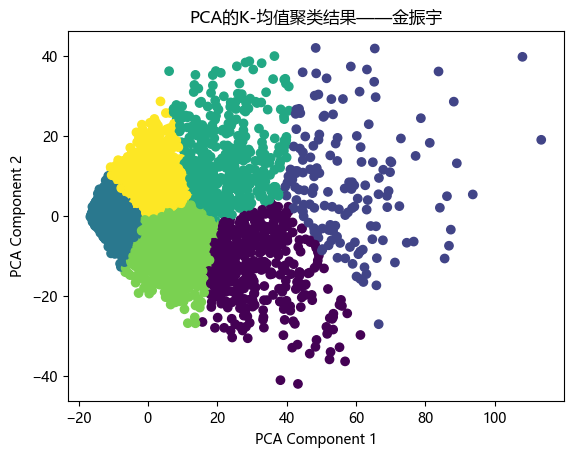

In [346]:
best_model = grid_search.best_estimator_
best_model.fit(pca_data)
labels = best_model.labels_
 
# 绘制散点图
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA的K-均值聚类结果——金振宇')
plt.show()

In [347]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
 
# 计算轮廓系数
silhouette_avg = silhouette_score(pca_data, labels)
print("轮廓系数:", silhouette_avg)
 
# 计算DB指数
db_index = davies_bouldin_score(pca_data, labels)
print("DB指数:", db_index)
 
ch_score = calinski_harabasz_score(pca_data, labels)
print("Calinski-Harabasz指数:", ch_score)

轮廓系数: 0.4720509566240093
DB指数: 0.8204326661233847
Calinski-Harabasz指数: 5955.452077184914


In [348]:
#提取聚类标签，形成聚类标签-用户id列表形式的字典
clustering_df=pd.DataFrame(columns=['user_id','label'])
clustering_df['user_id']=avg_ratings_by_genre.index.values
clustering_df['label']=labels
clustering_df.head()

,user_id,label
0,1,2
1,2,4
2,3,2
3,4,2
4,5,5


In [349]:
cluster_dict = clustering_df.groupby('label')['user_id'].apply(list).to_dict()

## 基于模型的协同过滤

### 准备数据集用于训练

In [350]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBaseline
from surprise.model_selection import GridSearchCV

# 设置Reader对象，指定line_format和分隔符，并跳过第一行（列标题）
reader = Reader(line_format='user item rating', sep=',', skip_lines=1)

# 加载数据集
data = Dataset.load_from_file('ratings1.csv', reader=reader)

# 将数据集分割为训练集和测试集
trainset, testset = train_test_split(data, test_size=0.2)


重新创建数据集，每个用户群体分别提取出来

In [351]:
#重新创建数据集，每个用户群体分别提取出来
cluster_train=dict()#储存每个类别的用户评分数据集
for cluster,id_ls in cluster_dict.items():
    # 提取多个用户的评分数据
    user_ratings = []
    for user_id in id_ls:
        user_inner_id = trainset.to_inner_uid(str(user_id))
        user_rating = trainset.ur[user_inner_id]
        user_ratings.extend([(trainset.to_raw_uid(user_inner_id), trainset.to_raw_iid(item_inner_id), rating)
                             for (item_inner_id, rating) in user_rating])
    # 将评分数据转换为DataFrame对象
    df = pd.DataFrame(user_ratings, columns=['user_id', 'item_id', 'rating'])
    # 创建一个新的数据集对象
    reader = Reader(rating_scale=(0.5, 5))  # 指定评分范围
    new_data = Dataset.load_from_df(df, reader)
    cluster_train[cluster]=new_data

测试集同样需要重新构建

In [352]:
#测试集同样需要重新构建
cluster_test=dict()
for cluster,id_ls in cluster_dict.items():
    ids=list(map(str,id_ls))
    # 从测试集中提取指定用户的数据
    target_user_data = [data for data in testset if data[0] in ids]
    cluster_test[cluster]=target_user_data

### 模型训练

对比使用模型：KNNBaseline、SVD、BaselineOnly

通过网格搜索为不同的用户群体找到了最适合的KNNBaseline模型，并保存了模型的详细信息，以便后续使用这些模型进行更准确的电影推荐。

In [353]:
#分别对每个用户群体进行网格搜索，找到最好的模型并保存下来
best_KBL_dict=dict()
param_grid = {'k': [30,40,50], 'sim_options': {'name': ['msd', 'cosine', 'pearson'], 'user_based': [True, False]}}
for cluster,id_ls in cluster_dict.items():
    best_model_info=dict()
    grid_search = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=5)
    grid_search.fit(cluster_train[cluster])
    best_model_info['best_aglo']=grid_search.best_estimator['rmse']
    best_model_info['best_params']=grid_search.best_params['rmse']
    best_model_info['score']=grid_search.best_score['rmse']
    best_KBL_dict[cluster]=best_model_info

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

SVD（奇异值分解）模型的参数优化。它使用了随机搜索（RandomizedSearchCV）来找到最佳的模型参数

In [354]:
from surprise import SVD
best_SVD_dict=dict()
param_grid = {'n_factors': [100,200,300,400],'n_epochs':[30,40,50,60],'lr_all': [0.001,0.005,0.01,0.05,0.1]}
for cluster,id_ls in cluster_dict.items():
    best_model_info=dict()
    grid_search = RandomizedSearchCV(SVD, param_grid, measures=['rmse'], cv=5,n_iter=3,random_state=42)
    grid_search.fit(cluster_train[cluster])
    best_model_info['best_aglo']=grid_search.best_estimator['rmse']
    best_model_info['best_params']=grid_search.best_params['rmse']
    best_model_info['score']=grid_search.best_score['rmse']
    best_SVD_dict[cluster]=best_model_info

通过网格搜索为不同的用户群体找到了最适合的 BaselineOnly 模型，并保存了模型的详细信息，以便后续使用这些模型进行更准确的推荐。

In [355]:
from surprise import BaselineOnly
from surprise.model_selection import GridSearchCV

best_BO_dict = dict()
param_grid = {
    'bsl_options': {
        'method': ['als', 'sgd'],
        'reg_u': [5, 10, 15],
        'reg_i': [5, 10, 15],
        'n_epochs': [20, 30, 40]
    }
}

for cluster, id_ls in cluster_dict.items():
    best_model_info = dict()
    grid_search = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=5)
    grid_search.fit(cluster_train[cluster])
    best_model_info['best_aglo'] = grid_search.best_estimator['rmse']
    best_model_info['best_params'] = grid_search.best_params['rmse']
    best_model_info['score'] = grid_search.best_score['rmse']
    best_BO_dict[cluster] = best_model_info


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

六个数据集分别对比3个模型，并选出最佳的模型，存入字典中

In [356]:
#六个数据集分别对比3个模型，并选出最佳的模型，存入字典中
cluster_aglo=[]
def find_best_aglo(model_lsit,clu):
    best_score=1000
    for model_dict in model_lsit:
        if best_score>model_dict[clu]['score']:
            best_score=model_dict[clu]['score']
            best_model=model_dict[clu]
    cluster_aglo.append(best_model)
    return cluster_aglo
# best_algo_dict=dict()
for cluster,id_ls in cluster_dict.items():
    find_best_aglo([best_BO_dict,best_KBL_dict,best_SVD_dict],cluster)

In [357]:
cluster_aglo

[{'best_aglo': <surprise.prediction_algorithms.knns.KNNBaseline at 0x293ef4a6810>,
  'best_params': {'k': 40,
   'sim_options': {'name': 'pearson', 'user_based': True}},
  'score': 0.8799582135295069},
 {'best_aglo': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x2943a483bd0>,
  'best_params': {'n_factors': 400, 'n_epochs': 30, 'lr_all': 0.05},
  'score': 0.863725783199641},
 {'best_aglo': <surprise.prediction_algorithms.baseline_only.BaselineOnly at 0x293dad75390>,
  'best_params': {'bsl_options': {'method': 'als',
    'reg_u': 5,
    'reg_i': 5,
    'n_epochs': 40}},
  'score': 0.9814219930477186},
 {'best_aglo': <surprise.prediction_algorithms.knns.KNNBaseline at 0x293e6b433d0>,
  'best_params': {'k': 40, 'sim_options': {'name': 'msd', 'user_based': True}},
  'score': 0.8728663421931839},
 {'best_aglo': <surprise.prediction_algorithms.knns.KNNBaseline at 0x29438307890>,
  'best_params': {'k': 50,
   'sim_options': {'name': 'msd', 'user_based': False}},
  'score': 0.92

In [358]:
for cluster,id_ls in cluster_dict.items():
    print([best_KBL_dict[cluster]['best_params'],best_BO_dict[cluster]['best_params'],best_SVD_dict[cluster]['best_params']])

[{'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}, {'bsl_options': {'method': 'sgd', 'reg_u': 5, 'reg_i': 5, 'n_epochs': 40}}, {'n_factors': 200, 'n_epochs': 40, 'lr_all': 0.05}]
[{'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}, {'bsl_options': {'method': 'sgd', 'reg_u': 5, 'reg_i': 5, 'n_epochs': 40}}, {'n_factors': 400, 'n_epochs': 30, 'lr_all': 0.05}]
[{'k': 50, 'sim_options': {'name': 'msd', 'user_based': True}}, {'bsl_options': {'method': 'als', 'reg_u': 5, 'reg_i': 5, 'n_epochs': 40}}, {'n_factors': 200, 'n_epochs': 50, 'lr_all': 0.05}]
[{'k': 40, 'sim_options': {'name': 'msd', 'user_based': True}}, {'bsl_options': {'method': 'sgd', 'reg_u': 5, 'reg_i': 5, 'n_epochs': 40}}, {'n_factors': 300, 'n_epochs': 60, 'lr_all': 0.05}]
[{'k': 50, 'sim_options': {'name': 'msd', 'user_based': False}}, {'bsl_options': {'method': 'sgd', 'reg_u': 5, 'reg_i': 5, 'n_epochs': 40}}, {'n_factors': 400, 'n_epochs': 50, 'lr_all': 0.05}]
[{'k': 50, 'sim_options': {'nam

In [370]:
from surprise import BaselineOnly
from surprise import accuracy  # 导入accuracy模块

num_clusters = 6

# 创建一个6x3的矩阵，用于存储RMSE、FCP和MAE
results_matrix = np.zeros((num_clusters, 3))

for i, (cluster, id_ls) in enumerate(cluster_dict.items()):
    model = cluster_aglo[cluster].get('best_aglo')
    if model is not None:
        model.fit(cluster_train[cluster].build_full_trainset())
        predictions = model.test(cluster_test[cluster])
        rmse, fcp, mae = accuracy.rmse(predictions), accuracy.fcp(predictions), accuracy.mae(predictions)
        results_matrix[i] = [rmse, fcp, mae]
    else:
        # 处理键不存在的情况
        print(f"Key 'best_aglo' not found for cluster {cluster}")

print("Results Matrix:")
print(results_matrix)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8764
FCP:  0.7450
MAE:  0.6861
RMSE: 0.8523
FCP:  0.7563
MAE:  0.6698
Estimating biases using als...
RMSE: 0.9735
FCP:  0.6720
MAE:  0.7734
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8628
FCP:  0.7315
MAE:  0.6798
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9217
FCP:  0.7080
MAE:  0.7261
Estimating biases using sgd...
RMSE: 0.8949
FCP:  0.6920
MAE:  0.7048
Results Matrix:
[[0.87641098 0.74503944 0.68612803]
 [0.85231239 0.7563346  0.66979309]
 [0.9734863  0.67197623 0.7733801 ]
 [0.86277648 0.73149505 0.67980234]
 [0.92171123 0.70797113 0.72606501]
 [0.89487367 0.69199217 0.70483491]]


In [360]:
data = data.build_full_trainset()

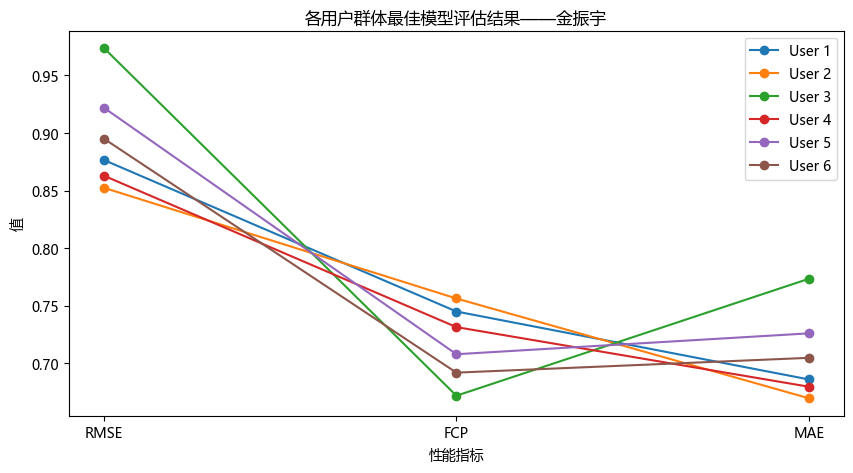

In [402]:
# 创建一个新的图形
plt.figure(figsize=(10, 5))

# 遍历结果字典并绘制每个模型的性能指标
for model, metrics in results.items():
    plt.plot(list(metrics.keys()), list(metrics.values()), marker='o', label=model)

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('各用户群体最佳模型评估结果——金振宇')
plt.xlabel('性能指标')
plt.ylabel('值')

# 显示图形
plt.show()


In [362]:
movies=pd.read_csv("movies.csv")
movies=dict(zip(list(map(str,movies['movie_id'].values.tolist())),movies['title'].values.tolist()))
def recommendation_movie(uid):
    for cluster,id_ls in cluster_dict.items():
        if uid in id_ls:
            uid_cluster=cluster
            break
    else:
        return 'user no in clusters'
    model=cluster_aglo[uid_cluster]['best_aglo']
    test_set = data.build_anti_testset()
    test_set = [item for item in test_set if item[0] == str(uid)]
    predictions = model.test(test_set)
    # 根据预测评分排序，获取排名前10的电影
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
    top_movies = top_predictions[:5]
    top_movies_rating=[]
    for item in top_movies:
        top_movies_rating.append([item.iid,item.est])
    # print(top_movies)
    # 输出推荐结果
    print("The user {} is in cluster {}".format(uid,uid_cluster+1))
    print("Top 5 recommended movies for user", uid)
    for movie_id, rating in top_movies_rating:
        print(movies[movie_id], "estimated rating:", rating)

In [363]:
recommendation_movie(18)

The user 18 is in cluster 5
Top 5 recommended movies for user 18
Shawshank Redemption, The (1994) estimated rating: 5
American History X (1998) estimated rating: 4.978520863229363
Goodfellas (1990) estimated rating: 4.9669607874736705
Sixth Sense, The (1999) estimated rating: 4.9151169583346705
Life Is Beautiful (La Vita è bella) (1997) estimated rating: 4.91041872330931
